In [2]:
import torch

In [3]:
torch.empty(5, 3)

tensor([[ 0.0000e+00,  2.0000e+00, -6.2170e+32],
        [ 1.5849e+29,  1.1210e-44,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])

In [4]:
torch.rand(5, 3)

tensor([[0.0290, 0.7536, 0.4018],
        [0.3132, 0.0028, 0.6553],
        [0.4663, 0.0589, 0.5638],
        [0.0405, 0.0353, 0.9120],
        [0.7697, 0.8639, 0.8471]])

In [13]:
x = torch.zeros(5, 3, dtype=torch.long)
x

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])

In [14]:
x = torch.tensor([3.3, 5])
x

tensor([3.3000, 5.0000])

In [15]:
x = x.new_ones(5, 3, dtype=torch.double)

In [16]:
torch.randn_like(x, dtype=torch.float)

tensor([[ 1.0136, -0.9861, -0.7379],
        [-0.6395, -0.2944,  1.5987],
        [-0.0534, -0.3049, -0.2917],
        [ 2.4367, -0.3919,  1.9873],
        [ 0.8687, -0.7861, -1.0693]])

In [17]:
y = torch.rand(5, 3)

In [18]:
x + y

tensor([[1.3015, 1.5363, 1.4194],
        [1.8083, 1.6153, 1.2227],
        [1.5909, 1.3526, 1.5095],
        [1.7160, 1.3498, 1.1375],
        [1.5191, 1.6559, 1.2612]], dtype=torch.float64)

In [21]:
x = torch.randn(4, 4)
y = x.view(16)
y

tensor([ 0.2453,  0.5872,  1.0513, -0.2208, -1.0339, -0.0752,  0.3489,  0.8131,
         0.8910,  0.7885, -0.5863,  1.5158, -0.3403,  0.4298, -0.2045,  1.6901])

## Autograd

In [180]:
x = torch.ones(2, 2, requires_grad=True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

In [181]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

In [182]:
y.grad_fn

In [199]:
z = y * y * 3
out = z.mean()
z, out

(tensor([[27., 27.],
         [27., 27.]], grad_fn=<MulBackward0>),
 tensor(27., grad_fn=<MeanBackward0>))

In [200]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a * a).sum()
print(b.grad_fn)

False
True


In [201]:
out.backward()
print(x.grad)

tensor([[18., 18.],
        [18., 18.]])


In [202]:
x = torch.randn(3, requires_grad=True)
y = x * 2
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ -214.5830,   415.1213, -1153.9406], grad_fn=<MulBackward0>)


In [203]:
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


## Neural networks

### 1. Define the network

In [214]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        
        return num_features

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [208]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 3, 3])


In [215]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.0310, -0.0704,  0.1104,  0.0189,  0.1160,  0.0625, -0.1128, -0.0749,
         -0.0375, -0.1211]], grad_fn=<AddmmBackward>)


In [216]:
net.zero_grad()
out.backward(torch.randn(1, 10))

### 2. Loss Function

In [218]:
output = net(input)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.6735, grad_fn=<MseLossBackward>)


In [226]:
loss.grad_fn.next_functions[0][0].next_functions

((<AccumulateGrad at 0x139a12bd0>, 0),
 (<ReluBackward0 at 0x139a12f90>, 0),
 (<TBackward at 0x13994d490>, 0))

In [229]:
net.zero_grad()
print(net.conv1.bias.grad)
loss.backward()
print(net.conv1.bias.grad)

tensor([0., 0., 0., 0., 0., 0.])
tensor([-0.0147, -0.0072,  0.0023, -0.0086, -0.0049,  0.0106])


### 3. Update the weights

In [230]:
import torch.optim as optim

learning_rage = 0.01

for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rage)
    
optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

## Training a classifier

### 1. Loading and normalizing CIFAR10

In [232]:
import torch
import torchvision
import torchvision.transforms as transforms

In [248]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


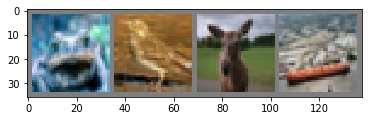

frog  bird  deer  ship 


In [261]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join([f'{classes[labels[j]]:5s}' for j in range(4)]))

### 2. Define a Convolutional Neural Network

In [262]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. Define a Loss function and optimizer

In [263]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [264]:
for epoch in range(2):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d} loss: {running_loss / 2000:.3f}]')
            running_loss = 0.0

print('Finished Training')

[1,  2000 loss: 2.151]
[1,  4000 loss: 1.800]
[1,  6000 loss: 1.654]
[1,  8000 loss: 1.556]
[1, 10000 loss: 1.514]
[1, 12000 loss: 1.432]
[2,  2000 loss: 1.374]
[2,  4000 loss: 1.336]
[2,  6000 loss: 1.308]
[2,  8000 loss: 1.300]
[2, 10000 loss: 1.278]
[2, 12000 loss: 1.258]
Finished Training


In [266]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

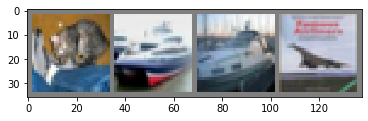

GroundTruth: cat   ship  ship  plane


In [269]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join([f'{classes[labels[j]]:5s}' for j in range(4)]))

In [272]:
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted:', ' '.join([f'{classes[labels[j]]:5s}' for j in range(4)]))

Predicted: cat   ship  ship  plane


In [273]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 53.34%


### 6. Training on GPU

In [274]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [275]:
net.to(device)
inputs, labels = data[0].to(device), data[1].to(device)

## Writing custom datasets, dataloaders and transforms

In [278]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import warnings
warnings.filterwarnings('ignore')

plt.ion()

Image name: 262007783_943bbcf613.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[123. 137.]
 [128. 176.]
 [137. 215.]
 [150. 250.]]


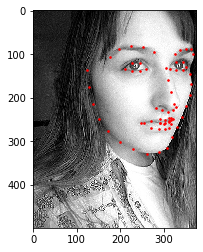

In [307]:
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')
n = 20
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print(f'Image name: {img_name}')
print(f'Landmarks shape: {landmarks.shape}')
print(f'First 4 Landmarks: {landmarks[:4]}')

def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

## Dataset class

In [309]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

0 (324, 215, 3) (68, 2)


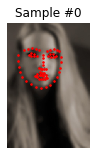

1 (500, 333, 3) (68, 2)


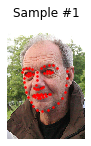

2 (250, 258, 3) (68, 2)


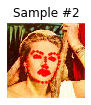

3 (434, 290, 3) (68, 2)


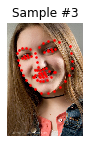

In [323]:
face_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv', root_dir='data/faces')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

## Transforms

In [324]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

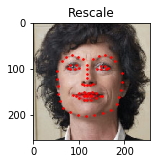

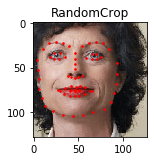

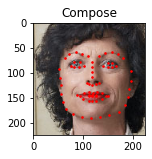

In [341]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

### Iterating through the dataset

In [342]:
transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


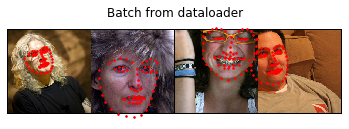

In [346]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

## Torchvision object detection finetuning tutorial